#Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
BASE_DIR = '/content/drive/My Drive/'
DATA_DIR = BASE_DIR + "data/"
FRAMES_INTERVAL = 10

In [3]:
pip install timesformer-pytorch

In [4]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat


#Attention

The attentation is represented using **Query-Key-Value** representation (QKV). It is like searching a Query, discover that this query is related with a specific Key and then return the Value associated with that key.

**Single-Head attention**

$Attention(Q, K, V) = Softmax(\frac{QK^T}{\sqrt{d_k}})*V$

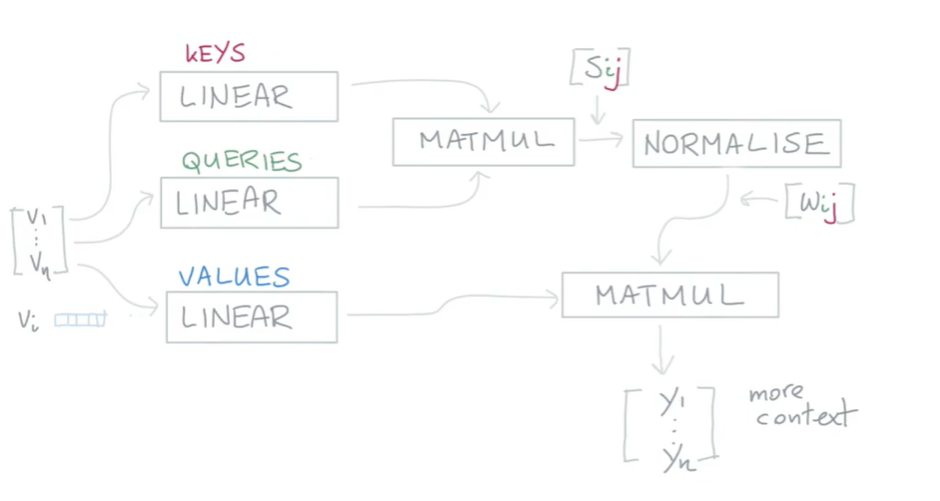


**Multi-Head attention**

$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)*W^O$
where $head_i = Attention(Q{W_i}^Q, K{W_i}^K, V{W_i}^V)$

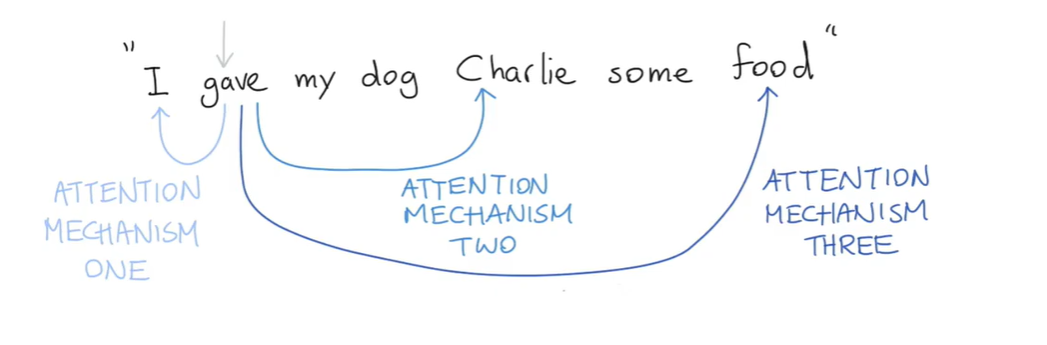

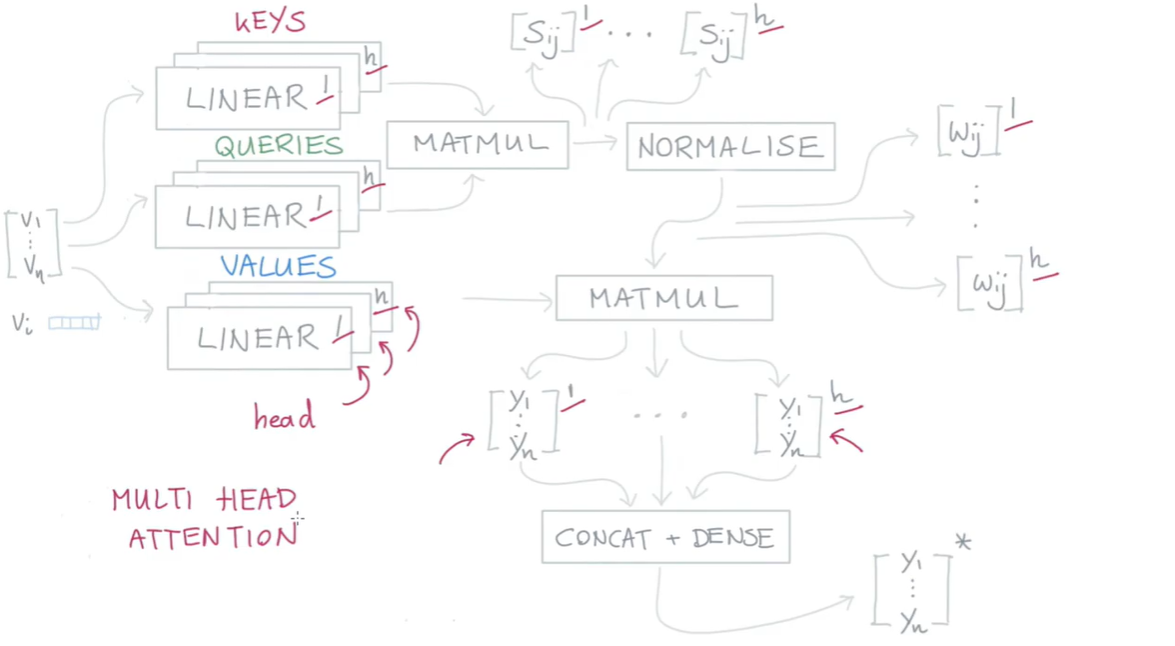


##Normalization

To calculate the Q,K,V vectors a normalization layer is needed. 

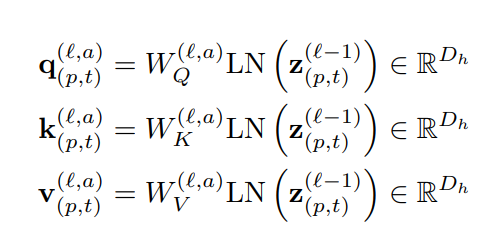

In [5]:
from google.colab.patches import cv2_imshow
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

## Feed Forward

In [6]:
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

## Divided Space-Time Attention

Self-attention weights are computed via dot-product. The self-attention weights for query patch (p, t) are given by:
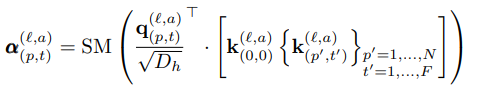

where SM denotes the softmax activation function.

In order to reduce computational cost we replace the spatiotemporal attention with spatial attention within each frame only. However, such a model neglects to capture temporal dependencies across frames. 
A more efficient architecture for spatiotemporal attention is **Divided Space-Time Attention** (T+S), where temporal attention and spatial attention are separateli applied one after the other. 

Within each blocl $l$, we first compute temporal attention by comparing each patch $(p, t)$ with all the patches at the same spatial location in other frames:

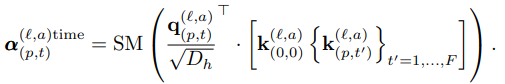

The resulting encoding, obtained using temporal attention, is then fed back for spatial attention computation instead of beign passed to the MLP. In other wordsd, new key/query/value vectors are obtained and spatial attention is then computed using:

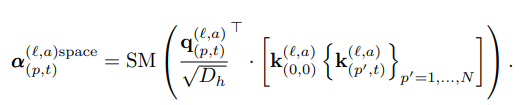

In [7]:
# attention

def attn(q, k, v):
    sim = einsum('b i d, b j d -> b i j', q, k)
    attn = sim.softmax(dim = -1)
    out = einsum('b i j, b j d -> b i d', attn, v)
    return out

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, einops_from, einops_to, **einops_dims):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        q *= self.scale

        # splice out classification token at index 1
        (cls_q, q_), (cls_k, k_), (cls_v, v_) = map(lambda t: (t[:, 0:1], t[:, 1:]), (q, k, v))

        # let classification token attend to key / values of all patches across time and space
        cls_out = attn(cls_q, k, v)

        # rearrange across time or space
        q_, k_, v_ = map(lambda t: rearrange(t, f'{einops_from} -> {einops_to}', **einops_dims), (q_, k_, v_))

        # expand cls token keys and values across time or space and concat
        r = q_.shape[0] // cls_k.shape[0]
        cls_k, cls_v = map(lambda t: repeat(t, 'b () d -> (b r) () d', r = r), (cls_k, cls_v))

        k_ = torch.cat((cls_k, k_), dim = 1)
        v_ = torch.cat((cls_v, v_), dim = 1)

        # attention
        out = attn(q_, k_, v_)

        # merge back time or space
        out = rearrange(out, f'{einops_to} -> {einops_from}', **einops_dims)

        # concat back the cls token
        out = torch.cat((cls_out, out), dim = 1)

        # merge back the heads
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)

        # combine heads out
        return self.to_out(out)


In [8]:
# main classes
class TimeSformer(nn.Module):
    def __init__(
        self,
        *,
        dim,
        num_frames,
        num_classes,
        image_size = 224,
        patch_size = 16,
        channels = 3,
        depth = 12,
        heads = 8,
        dim_head = 64,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_size // patch_size) ** 2
        num_positions = num_frames * num_patches
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.to_patch_embedding = nn.Linear(patch_dim, dim)
        self.pos_emb = nn.Embedding(num_positions + 1, dim)
        self.cls_token = nn.Parameter(torch.randn(1, dim))

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Time attention
                PreNorm(dim, Attention(dim, dim_head = dim_head, heads = heads, dropout = attn_dropout)), # Spatial attention
                PreNorm(dim, FeedForward(dim, dropout = ff_dropout)) # Feed Forward
            ]))

        self.to_out = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, video):
        b, f, _, h, w, *_, device, p = *video.shape, video.device, self.patch_size
        assert h % p == 0 and w % p == 0, f'height {h} and width {w} of video must be divisible by the patch size {p}'

        n = (h // p) * (w // p)
        video = rearrange(video, 'b f c (h p1) (w p2) -> b (f h w) (p1 p2 c)', p1 = p, p2 = p)
        
        tokens = self.to_patch_embedding(video)

        cls_token = repeat(self.cls_token, 'n d -> b n d', b = b)
        x =  torch.cat((cls_token, tokens), dim = 1)
        x += self.pos_emb(torch.arange(x.shape[1], device = device))

        for (time_attn, spatial_attn, ff) in self.layers:
            x = time_attn(x, 'b (f n) d', '(b n) f d', n = n) + x
            x = spatial_attn(x, 'b (f n) d', '(b f) n d', f = f) + x
            x = ff(x) + x

        cls_token = x[:, 0]
        
        return self.to_out(cls_token)

#Execution

In [9]:
import torch
import cv2
import numpy as np
import os
import math

preview = []
videos = []

# GET MIN VIDEO FRAME PER VIDEO: Videos may have different shapes
min_video_frames = math.inf 

for video_file_name in os.listdir(DATA_DIR):
  vidcap  = cv2.VideoCapture(DATA_DIR + video_file_name)
  length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  if length < min_video_frames:
    min_video_frames = length


# EXTRACT SOME FRAMES FROM VIDEOS
for video_file_name in os.listdir(DATA_DIR):
  print("Loading " + video_file_name + "...")
  vidcap  = cv2.VideoCapture(DATA_DIR + video_file_name)
  success, image = vidcap.read()
  considered_frames_counter = 0
  frames = []
  while success:    

    if considered_frames_counter == int(min_video_frames / FRAMES_INTERVAL) - 1:
      break

    success,image = vidcap.read()
    if considered_frames_counter == FRAMES_INTERVAL:
      preview.append((video_file_name, cv2.resize(image, (224,224))))
    if success and considered_frames_counter % FRAMES_INTERVAL == 0:
      image = np.transpose(np.asarray(cv2.resize(image, (224,224))), (2, 0, 1))
      frames.append(image)
    
    if success:
      considered_frames_counter += 1

  videos.append(frames)

model = TimeSformer(
    dim = 512,
    image_size = 224,
    patch_size = 16,
    num_frames = considered_frames_counter,
    num_classes = 10,
    depth = 12,
    heads = 8, # DIM / PATCH SIZE
    dim_head =  64, # DIM / HEADS
    attn_dropout = 0.1,
    ff_dropout = 0.1
)

video = torch.tensor(np.asarray(videos)).float() # (batch x frames x channels x height x width)

del videos

pred = model(video) # (batch x classes)


Loading rabbit.mov...
Loading rate.mov...
Loading waterfall.mov...
Loading lake.mov...
Loading slug.mov...
Loading chess.mov...
Loading city.mov...
Loading city2.mov...
Loading nature.mov...
Loading river.mov...
Loading dog.mov...
Loading dog2.mov...
Loading slug2.mov...
Loading dog3.mov...


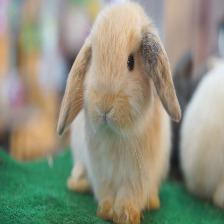

rabbit.mov
tensor([-0.3726,  0.0909, -0.0443,  0.3330,  0.2111,  1.5140,  0.3224, -0.3101,
         0.3393,  0.5766], grad_fn=<UnbindBackward>)
________________________________________________


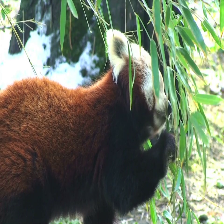

rate.mov
tensor([-0.5831,  0.3399, -0.2206,  0.3918,  0.4548,  1.5383,  0.4411, -0.1695,
         0.3424,  0.6320], grad_fn=<UnbindBackward>)
________________________________________________


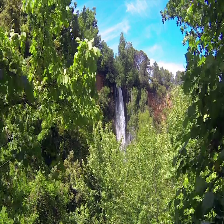

waterfall.mov
tensor([-0.3799,  0.4033, -0.3506,  0.5805,  0.6664,  1.5103,  0.2899, -0.4597,
         0.2760,  0.5586], grad_fn=<UnbindBackward>)
________________________________________________


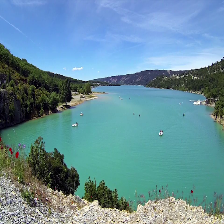

lake.mov
tensor([-0.3788,  0.2349, -0.0200,  0.4398,  0.3223,  1.4311,  0.4012, -0.1263,
         0.5358, -0.0241], grad_fn=<UnbindBackward>)
________________________________________________


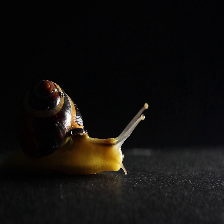

slug.mov
tensor([-0.4535, -0.0954, -0.3853,  0.5379,  0.4539,  1.5340,  0.3226, -0.4938,
         0.5396, -0.0403], grad_fn=<UnbindBackward>)
________________________________________________


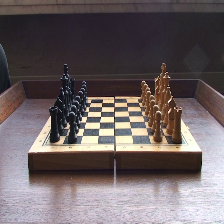

chess.mov
tensor([-0.4685,  0.1409, -0.2609,  0.5286,  0.1689,  1.3672,  0.1575, -0.1861,
         0.4965,  0.1020], grad_fn=<UnbindBackward>)
________________________________________________


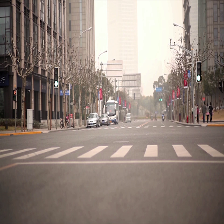

city.mov
tensor([-0.6704,  0.1669, -0.2680,  0.4844,  0.5198,  1.4727,  0.2830, -0.2282,
         0.6271,  0.4111], grad_fn=<UnbindBackward>)
________________________________________________


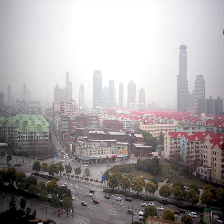

city2.mov
tensor([-0.4295,  0.1822, -0.3594,  0.5235,  0.5396,  1.3727,  0.3926, -0.5986,
         0.2894,  0.5471], grad_fn=<UnbindBackward>)
________________________________________________


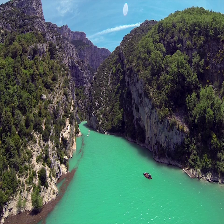

nature.mov
tensor([-0.3140, -0.0147, -0.1908,  0.5301,  0.2045,  1.2998,  0.2251, -0.4645,
         0.3868,  0.2937], grad_fn=<UnbindBackward>)
________________________________________________


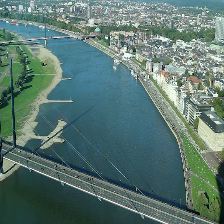

river.mov
tensor([-0.4074,  0.1138, -0.3994,  0.5054,  0.4182,  1.4015,  0.3104, -0.2066,
         0.4655,  0.3794], grad_fn=<UnbindBackward>)
________________________________________________


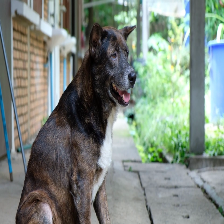

dog.mov
tensor([-0.6290,  0.0663, -0.1319,  0.3150,  0.4027,  1.3445,  0.6036, -0.2882,
         0.4118,  0.4547], grad_fn=<UnbindBackward>)
________________________________________________


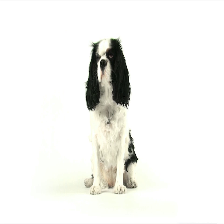

dog2.mov
tensor([-0.3215,  0.0235, -0.1832,  0.4828,  0.5294,  1.3708,  0.3984, -0.2097,
         0.6510,  0.3305], grad_fn=<UnbindBackward>)
________________________________________________


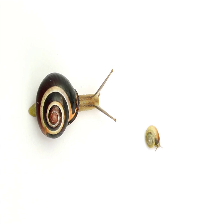

slug2.mov
tensor([-0.1940,  0.2442, -0.3388,  0.1122,  0.5844,  1.2020,  0.3744, -0.4619,
         0.3103,  0.1662], grad_fn=<UnbindBackward>)
________________________________________________


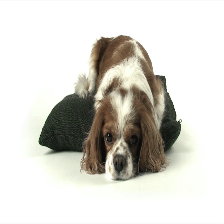

dog3.mov
tensor([-0.5595,  0.0378, -0.1772,  0.3766,  0.2360,  1.3405,  0.4110, -0.4188,
         0.4789,  0.5678], grad_fn=<UnbindBackward>)
________________________________________________


In [10]:
for index, prediction in enumerate(pred):
  considered_video = preview[index]
  cv2_imshow(considered_video[1])
  print(considered_video[0])
  print(prediction)
  print("________________________________________________")
